**Création de l'environnement virtuel python**

 ```
$ mkdir pip_serietemp
$ python3.9 -m venv pip_serietemp
$ source pip_serietemp/bin/activate
$ python3.9 -m pip install --upgrade pip
$ python3.9 -m pip install jupyter
$ python3.9 -m pip install pandas
$ python3.9 -m pip install matplotlib
$ python3.9 -m pip install scipy
$ python3.9 -m pip install statsmodels
$ python3.9 -m pip install seaborn
$ jupyter notebook
```

**Modèle : AR - MA - ARIMA - SARIM**

# Lecture et Analyse 

## Prévision d'une série temporelle

Ici, on suppose que le signal (ou l'une de ses dérivées) est un processus stationnaire.

Dans un exemple, on ajouera la composante saisonnière.

### Import des modules


In [1]:
# Clone the repo containing the dataset
!git clone -l -s https://github.com/mikeguzman1294/PythonDataScience.git cloned-repo
%cd cloned-repo/Courses/TimeSeries

Cloning into 'cloned-repo'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 47 (delta 7), reused 35 (delta 3), pack-reused 0
Unpacking objects: 100% (47/47), done.
/content/cloned-repo/Courses/TimeSeries


In [2]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

### Lecture des données

On utilisera un dataset présent statsmodels. Nous avons choisi l'ensemble de données appelé «$CO_2$ atmosphérique provenant d’échantillons d’air continus à l’observatoire du Mauna Loa, Hawaii, États-Unis», qui a recueilli des échantillons de $CO_2$ de mars 1958 à décembre 2020. 

Dr. Pieter Tans, NOAA/GML (www.esrl.noaa.gov/gmd/ccgg/trends/) and Dr. Ralph Keeling, Scripps Institution of Oceanography (scrippsco2.ucsd.edu/).

J'ai choisi le fichier d'un relevé mensuel (il existe plusieurs fichiers).

In [3]:
data = sm.datasets.co2.load_pandas()

train = pd.read_csv('Data/co2_mm_mlo.csv',sep=';',parse_dates=['date1'])

train1=train[['date1','co2']]
print(train1.head())

y=train[['date1','co2']]
print(y.head())

y=pd.Series(train['co2'].values, index=train['date1'])

       date1     co2
0 1958-03-01  315.70
1 1958-04-01  317.45
2 1958-05-01  317.51
3 1958-06-01  317.24
4 1958-07-01  315.86
       date1     co2
0 1958-03-01  315.70
1 1958-04-01  317.45
2 1958-05-01  317.51
3 1958-06-01  317.24
4 1958-07-01  315.86


In [4]:
print(y.dtypes)

float64


In [5]:
y.describe()

count    764.000000
mean     356.532657
std       29.691066
min      312.430000
25%      329.365000
50%      353.505000
75%      380.650000
max      419.130000
dtype: float64

In [6]:
print(y)

date1
1958-03-01    315.70
1958-04-01    317.45
1958-05-01    317.51
1958-06-01    317.24
1958-07-01    315.86
               ...  
2021-06-01    418.94
2021-07-01    416.96
2021-08-01    414.47
2021-09-01    413.30
2021-10-01    413.93
Length: 764, dtype: float64


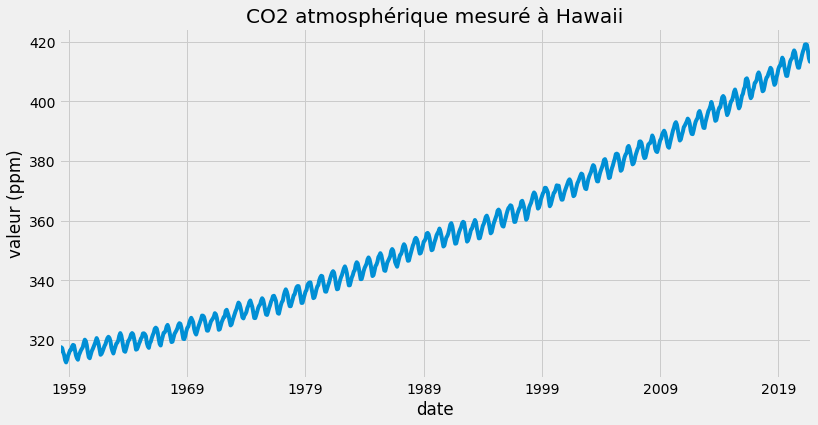

In [7]:
plt.figure(figsize=(12,6))
y.plot()
plt.gca().set(title='CO2 atmosphérique mesuré à Hawaii', xlabel='date', ylabel='valeur (ppm)')
plt.show()

A priori, nous avons une saisonnalité de 12 mois.

# Modélisation

- Définir une plage de valeurs à tester (pour le modèle SARIMAX)

- Minimisation d'un critère (AIC, BIC, MSE, MAE,...)


Pour calculer les déterminer les modèle ARIMA, SARIMA,... on va utiliser la fonction SARIMAX.


https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html


## Modèle ARIMA (uniquement)

Le modèle arima est défini par un triplet $(p,d,q)$.

où :

- p : ordre de la partie AR
- d : ordre de la différentiation
- q : ordre de la partie MA

**Méthodologie**


- Etape 1 : Observation de l'autocorrélation et de l'autocorrélation partielle,
- Etape 2 : Étude de la stationnarité,
- Etape 3 : Modélisation ARIMA
- Etape 4 : Recherche du meilleur triplet

### Etude des corrélation et de la stationnarité

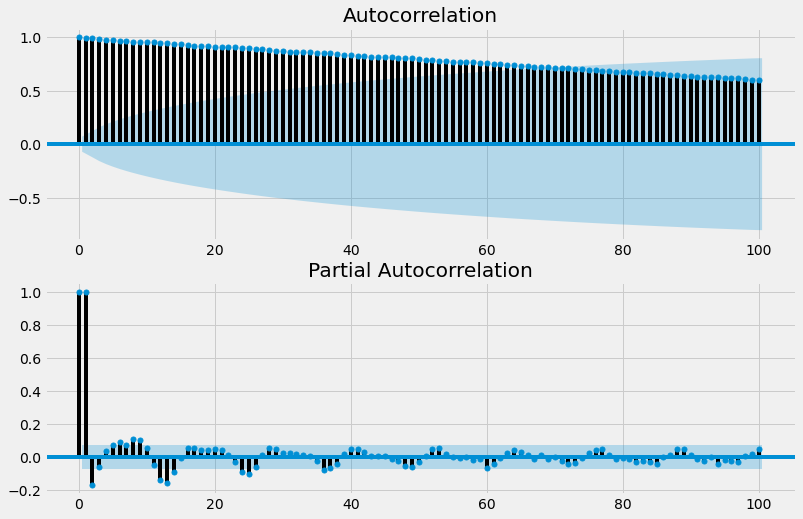

In [8]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y, lags=100, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y, lags=100, ax=ax2)# , lags=40


- L'autocorrélation décroit (faiblement)

- Lautocorrélation partielle possède 2 gros pics, une valeur plus faible mais significative puis des valeurs qui sont plus faibles (qui snt juste au dessus de la limite).

In [9]:
from statsmodels.tsa.stattools import adfuller

# cette fonction a été complétée afin d'observer le signal 
# et d'expliquer le résultat du test (on peut se contenter de la p-value 
# et de la valeur du test)

def test_stationarity(timeseries, window = 36, cutoff = 0.01):
    
    #Perform Dickey-Fuller test:
    print('Resultats du Test de Dickey-Fuller :')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 36 )
    # maxlag et autolag
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistique','p-value','#Lags utilisés','Nombre d observations utilisées'])
    for key,value in dftest[4].items():
        dfoutput['Valeur critique (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. La série est vraisemblablement stationnaire.' % pvalue)
    else:
        print('p-value = %.4f. La série est vraisemblablement non stationnaire.' % pvalue)
    
    print(dfoutput)

In [10]:
test_stationarity(y,36)

Resultats du Test de Dickey-Fuller :
p-value = 1.0000. La série est vraisemblablement non stationnaire.
Test Statistique                     5.120641
p-value                              1.000000
#Lags utilisés                      36.000000
Nombre d observations utilisées    727.000000
Valeur critique (1%)                -3.439377
Valeur critique (5%)                -2.865524
Valeur critique (10%)               -2.568891
dtype: float64


Le test de Dickey-Fuller permet de tester la stationnarité d'une suite de valeurs.

p-value = 1 (trop élévé)

La valaue du Test Statistique (5.12) est trop grande (on veut qu'elle soit inférieure à -3.4 ou -2.8 ou -2.5 selon la valeur critique)

L'hypothèse est acceptée si la p-value est faible (~$10^{-2}$) c'est-à-dire la valeur du test inférieure à la valeur critique.

In [11]:
first_diff = y - y.shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 40)

Resultats du Test de Dickey-Fuller :
p-value = 0.2438. La série est vraisemblablement non stationnaire.
Test Statistique                    -2.101697
p-value                              0.243833
#Lags utilisés                      36.000000
Nombre d observations utilisées    726.000000
Valeur critique (1%)                -3.439389
Valeur critique (5%)                -2.865529
Valeur critique (10%)               -2.568894
dtype: float64


La p-value a diminué mais elle reste trop éléve. La valeur du test statistique reste supérieure à $-2.5$.

In [12]:
seconde_diff = first_diff - first_diff.shift(1)
seconde_diff = seconde_diff.dropna(inplace = False)
test_stationarity(seconde_diff, window = 40)

Resultats du Test de Dickey-Fuller :
p-value = 0.0000. La série est vraisemblablement stationnaire.
Test Statistique                  -9.907623e+00
p-value                            3.231882e-17
#Lags utilisés                     3.600000e+01
Nombre d observations utilisées    7.250000e+02
Valeur critique (1%)              -3.439402e+00
Valeur critique (5%)              -2.865535e+00
Valeur critique (10%)             -2.568897e+00
dtype: float64


Ici, on remarque qu'il est nécessiare de dériver deux fois le signal pour qu'il soit stationnaire.

Quel triplet tester ?

Le test sur la stationnarité donne : d = 2

L'auto-corrélation partiel nous donne une valeur $p$ égale à 2 ou 3. 

Pour la valeur de $q$, on peut commencer par 0 puis augmenter doucement l'ordre.

In [13]:
print(y.head)

mod = sm.tsa.statespace.SARIMAX(y,
                               order=(3, 2, 0),
                               enforce_stationarity=False,
                               enforce_invertibility=False)

results = mod.fit(disp=False)

print(results.summary()) #.tables[1])

<bound method NDFrame.head of date1
1958-03-01    315.70
1958-04-01    317.45
1958-05-01    317.51
1958-06-01    317.24
1958-07-01    315.86
               ...  
2021-06-01    418.94
2021-07-01    416.96
2021-08-01    414.47
2021-09-01    413.30
2021-10-01    413.93
Length: 764, dtype: float64>


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  764
Model:               SARIMAX(3, 2, 0)   Log Likelihood                -963.447
Date:                Tue, 15 Nov 2022   AIC                           1934.894
Time:                        15:39:32   BIC                           1953.422
Sample:                    03-01-1958   HQIC                          1942.029
                         - 10-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2666      0.038      7.096      0.000       0.193       0.340
ar.L2          0.0049      0.039      0.125      0.901      -0.072       0.081
ar.L3         -0.3299      0.038     -8.775      0.0

- L’attribut results.summary() renvoie une quantité importante d’informations (valeurs des coeff., std err,z, P>|z|et intervalle confiance.
- La colonne "coef" indique le poids (c’est-à-dire importance) de chaque caractéristique et son impact sur la série chronologique. 
- La colonne "P> | z |" nous informe de la signification de chaque poids caractéristique. Ici, chaque poids a une valeur p inférieure ou proche de "0.05", il est donc raisonnable de les conserver tous dans notre modèle.

- Log-likelihood : logarithme du maximum de la fonction de vraisemblance (pour le modèle considéré)

$${\displaystyle \ln({\hat {L}})}$$

- Akaike information criterion (AIC) 

$${\displaystyle \mathrm {AIC} \,=\,2k-2\ln({\hat {L}})}$$

- Bayesian information criterion (BIC)

$${\displaystyle \mathrm {BIC} =k\ln(n)-2\ln({\hat {L}})}$$

- Hannan–Quinn information criterion (HQIC)

$${\displaystyle \mathrm {HQC} =-2\ln({\hat {L}})+2k\ln(\ln(n))}$$

où $k$ est le nombre de paramètres et $n$ est le nombre d'observation.

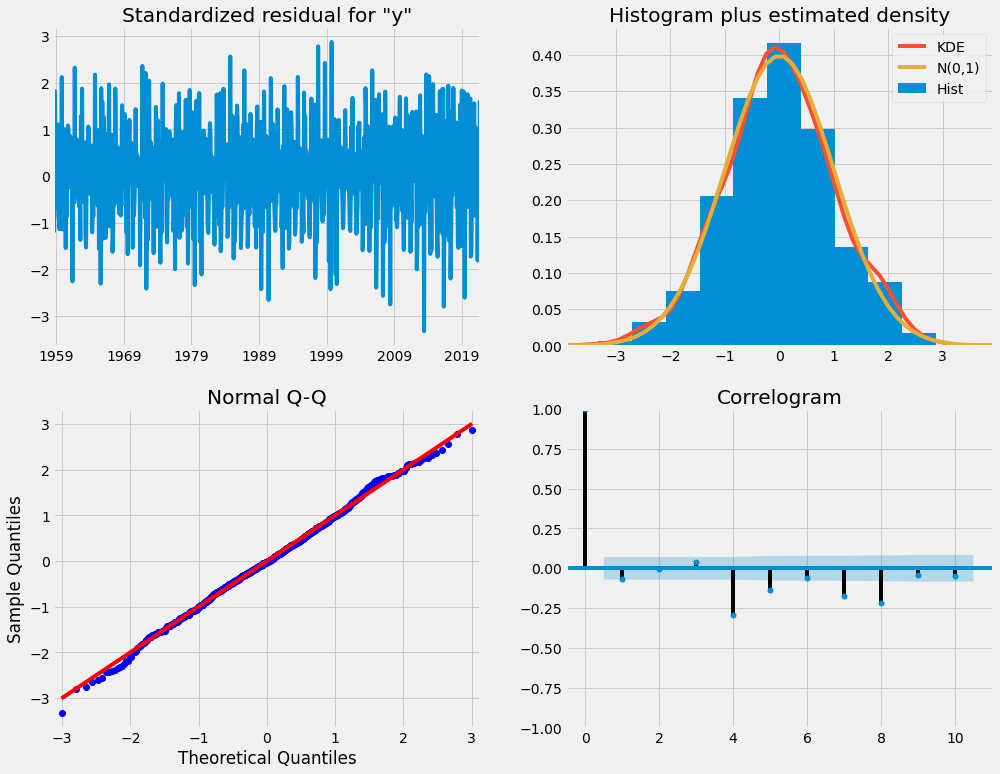

In [14]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

764
NormaltestResult(statistic=1184.3828976202396, pvalue=6.524114155244745e-258)
0.11539278447844116 14.402168776246258


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Residual distribution')

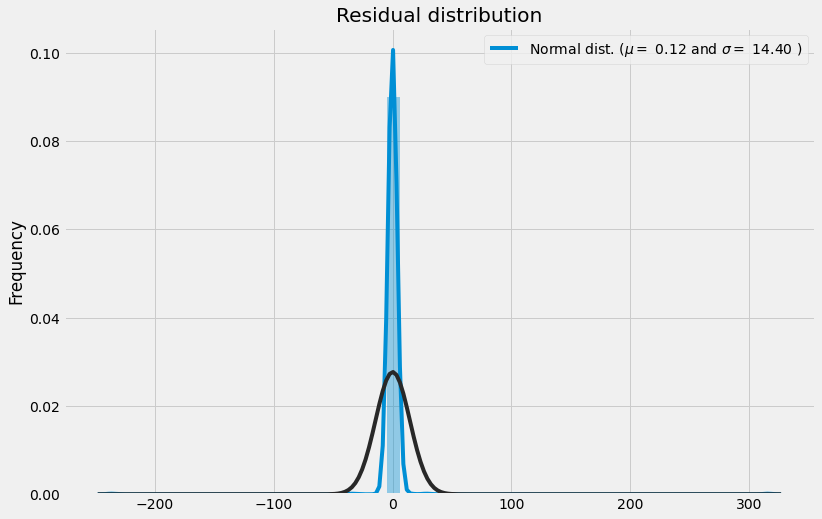

In [15]:
import seaborn as sns # affichage
from scipy import stats
from scipy.stats import normaltest

resid = results.resid
print(resid.size)
print(normaltest(resid))

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)
print(mu, sigma)
fig = plt.figure(figsize=(12,8))
#ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm) # need to import scipy.stats


#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], \
           loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')



Le test de normalité nous indique que le bruit est gaussien. Par contre, il reste quelques corrélation.

Pour trouver les valeurs $(p,d,q)$, on utilisera ici la force brute en créant les différents triplet possibles. Puis en essayant recherchant la triplet ayant une valeur AIC la plus faible posssible.


In [16]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))


print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} '.format(pdq[1]))
print('SARIMAX: {} '.format(pdq[2]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) 
SARIMAX: (0, 0, 2) 


In [17]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

aic_min = 10000.

for param in pdq:
    try:
        mod = sm.tsa.statespace.SARIMAX(y,
                                        order=param,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        results = mod.fit(disp=False)
           
        if results.aic < aic_min:
            print('ARIMA{} - AIC:{}'.format(param, results.aic))
            aic_min = results.aic
            
    except:
        continue

ARIMA(0, 0, 2) - AIC:9035.736933933023
ARIMA(0, 0, 3) - AIC:8068.331314574794
ARIMA(0, 1, 0) - AIC:2491.0122468958198
ARIMA(0, 1, 1) - AIC:2025.4532655652306
ARIMA(0, 1, 2) - AIC:1843.813552708499
ARIMA(0, 1, 3) - AIC:1739.352292882003
ARIMA(2, 1, 1) - AIC:1606.5077277070316
ARIMA(2, 1, 2) - AIC:1605.3800823756778
ARIMA(2, 1, 3) - AIC:1601.2238687236343
ARIMA(3, 2, 2) - AIC:1470.000469027405


In [18]:
mod = sm.tsa.statespace.SARIMAX(y,
                               order=(3, 2, 2),
                               enforce_stationarity=False,
                               enforce_invertibility=False)

results = mod.fit(disp=False)

print(results.summary()) #.tables[1])

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  764
Model:               SARIMAX(3, 2, 2)   Log Likelihood                -729.000
Date:                Tue, 15 Nov 2022   AIC                           1470.000
Time:                        15:40:13   BIC                           1497.792
Sample:                    03-01-1958   HQIC                          1480.703
                         - 10-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5256      0.031     49.063      0.000       1.465       1.587
ar.L2         -0.8094      0.049    -16.644      0.000      -0.905      -0.714
ar.L3         -0.0302      0.028     -1.068      0.2

https://docs.w3cub.com/statsmodels/generated/statsmodels.tsa.statespace.sarimax.sarimaxresults.get_prediction

In [19]:
pred = results.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=True)
pred_ci = pred.conf_int()

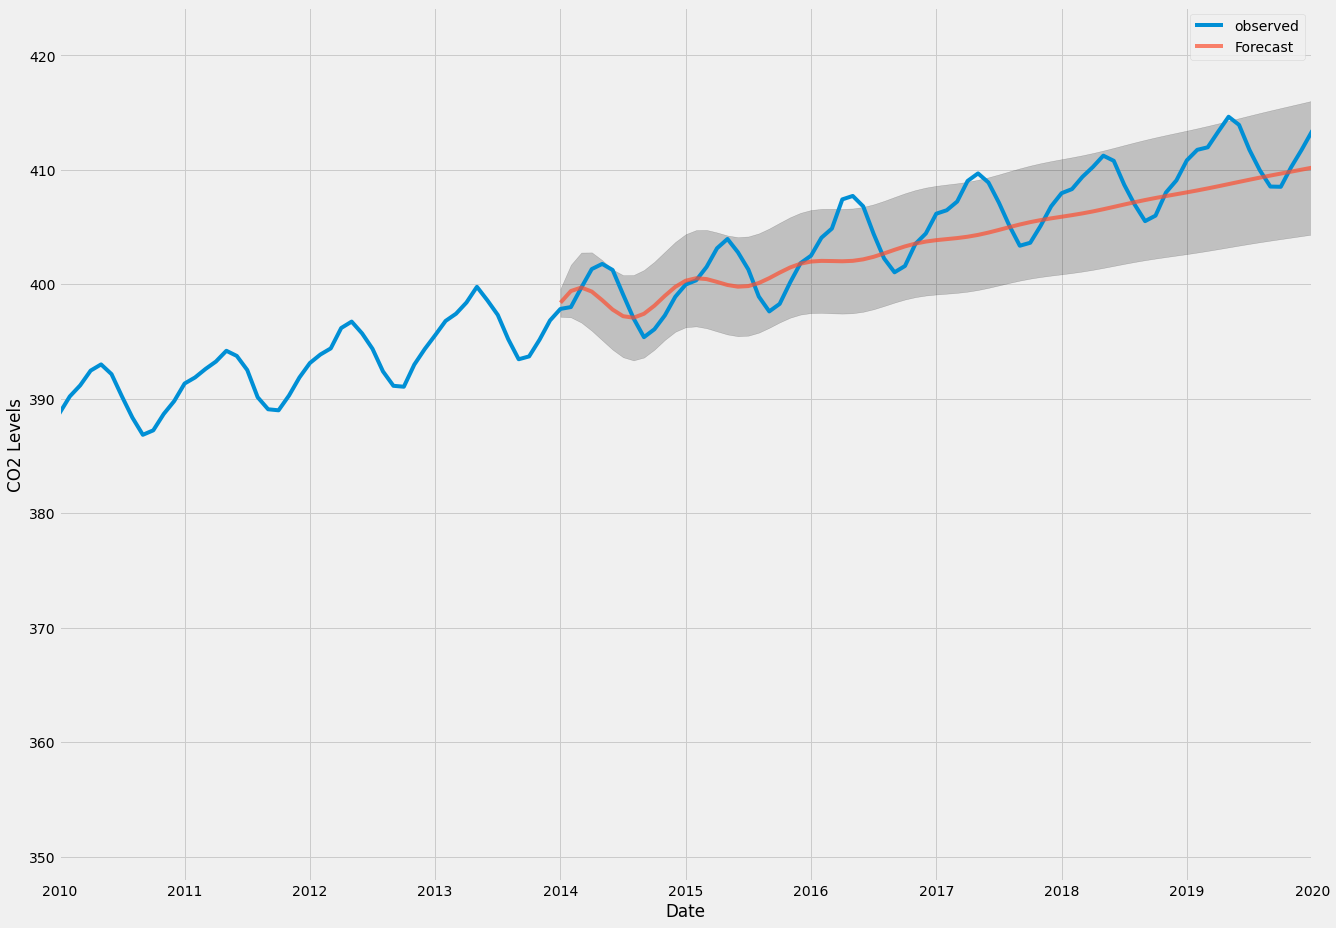

In [20]:
ax = y['1990':].plot(label='observed', figsize=(20, 15))
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.xlim([480., 600.])
plt.show()

L'inconvénient d'un modèle ARIMA est la pertre d'un saisonnalité dans la préduction (qui devient linéaire). On sens que la tendance est suivie. L'inccertitude augmente avec le temps.

### Modèle SARIMA

In [21]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

#(ici 2^6=64 combinaisons, 3^6=729, 4^6=4096)

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [22]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

aic_min = 10000.

for param in pdq:
   for param_seasonal in seasonal_pdq:
       try:
           mod = sm.tsa.statespace.SARIMAX(y,
                                           order=param,
                                           seasonal_order=param_seasonal,
                                           enforce_stationarity=False,
                                           enforce_invertibility=False)

           results = mod.fit(disp=False)
           
           if results.aic < aic_min:
               print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
               aic_min = results.aic
            
       except:
           continue
            
            

# aic (float) Akaike Information Criterion
# aicc (float) Akaike Information Criterion with small sample correction
# bic (float) Bayes Information Criterion
# bse The standard errors of the parameter estimates.

# hqic (float) Hannan-Quinn Information Criterion
# llf (float) The value of the log-likelihood function evaluated at params.
# llf_obs (float) The value of the log-likelihood function evaluated at params.

# mae (float) Mean absolute error
# mse (float) Mean squared error
# resid (array) The model residuals.
# sse (float) Sum of squared errors
        

ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:3006.863648201832
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:2525.3159200045748
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:1615.8770664446934
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:1607.2159541061233
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:1404.6149170952885
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:1205.0884931624882
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:1082.1947772887775
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:868.015876801883
ARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC:458.9761356496281
ARIMA(0, 1, 0)x(1, 1, 1, 12) - AIC:456.7976095720377
ARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC:369.0920705976695
ARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC:368.2553070675692
ARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC:366.51975497704
ARIMA(1, 1, 1)x(1, 1, 1, 12) - AIC:366.06411672672516


La valeur la plus faible "AIC" est de de 357.6 pour SARIMAX (1, 1, 1) x (1, 1, 1, 12).

En augmentant les espace de recherche on obtient :

- SARIMAX (2, 0, 2)x(0, 1, 2, 12)  AIC:293.7 (très long)

- SARIMAX (1, 1, 1)x(3, 1, 3, 12)  AIC:251.0 (très très long)

- SARIMAX (1, 1, 1)x(2, 1, 3, 12) - AIC:341.04095730743916

Nous devrions donc considérer cette option comme optimale parmi tous les modèles que nous avons examinés.

In [23]:
mod = sm.tsa.statespace.SARIMAX(y,
                               order=(1, 1, 1),
                               seasonal_order=(3, 1, 3, 12),
                               enforce_stationarity=False,
                               enforce_invertibility=False)

results = mod.fit(disp=False)

print(results.summary()) #.tables[1])

                                         SARIMAX Results                                          
Dep. Variable:                                          y   No. Observations:                  764
Model:             SARIMAX(1, 1, 1)x(3, 1, [1, 2, 3], 12)   Log Likelihood                -168.761
Date:                                    Tue, 15 Nov 2022   AIC                            355.523
Time:                                            15:41:23   BIC                            396.648
Sample:                                        03-01-1958   HQIC                           371.407
                                             - 10-01-2021                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1454      0.087      1.671      0

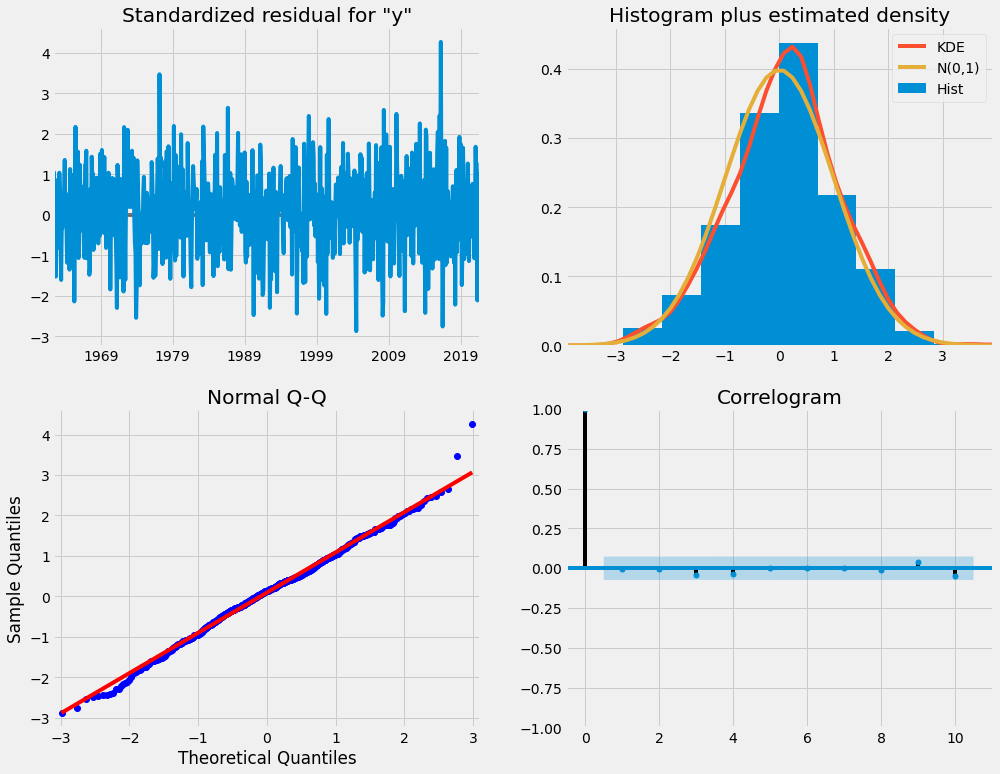

764
NormaltestResult(statistic=1630.1151679339864, pvalue=0.0)


In [24]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

resid = results.resid
print(resid.size)
print(normaltest(resid))

Pour comparaison : on affiche le résultat pour order=(1, 1, 1) et order=(0, 0, 0),seasonal_order=(0, 1, 0, 12),

In [25]:
mod = sm.tsa.statespace.SARIMAX(y,
                               order=(1, 1, 1),
                               enforce_stationarity=False,
                               enforce_invertibility=False)

results = mod.fit(disp=False)

print(results.summary()) #.tables[1])

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  764
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -928.674
Date:                Tue, 15 Nov 2022   AIC                           1863.349
Time:                        15:41:24   BIC                           1877.253
Sample:                    03-01-1958   HQIC                          1868.703
                         - 10-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5668      0.041     13.788      0.000       0.486       0.647
ma.L1          0.3680      0.045      8.168      0.000       0.280       0.456
sigma2         0.6722      0.040     16.758      0.0

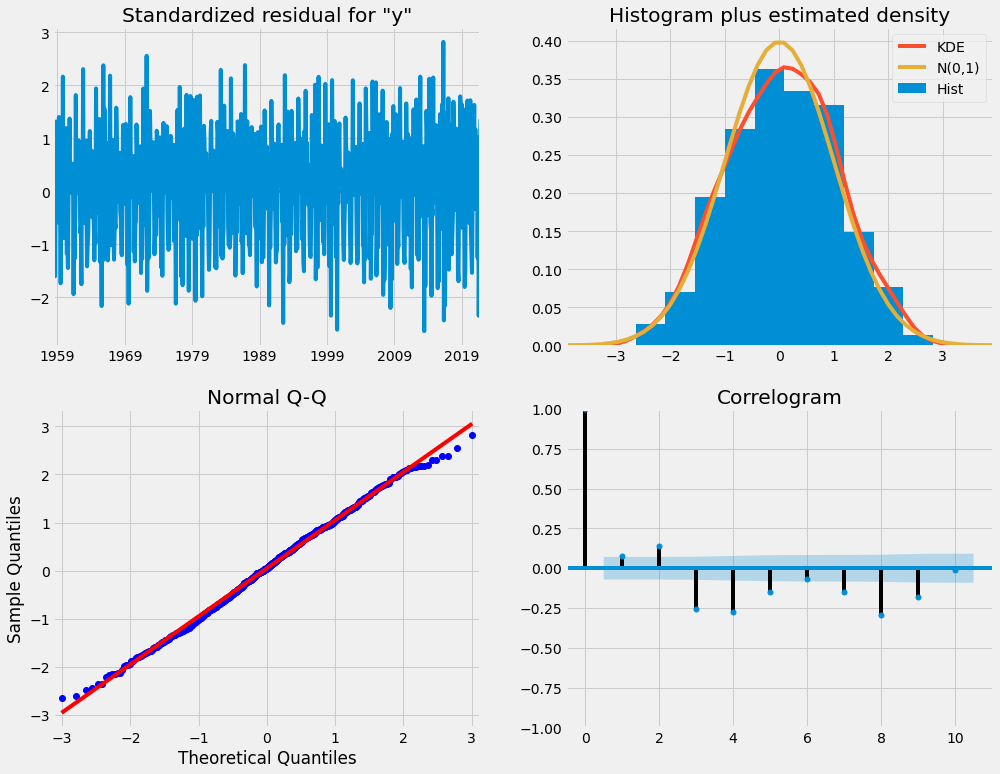

In [26]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

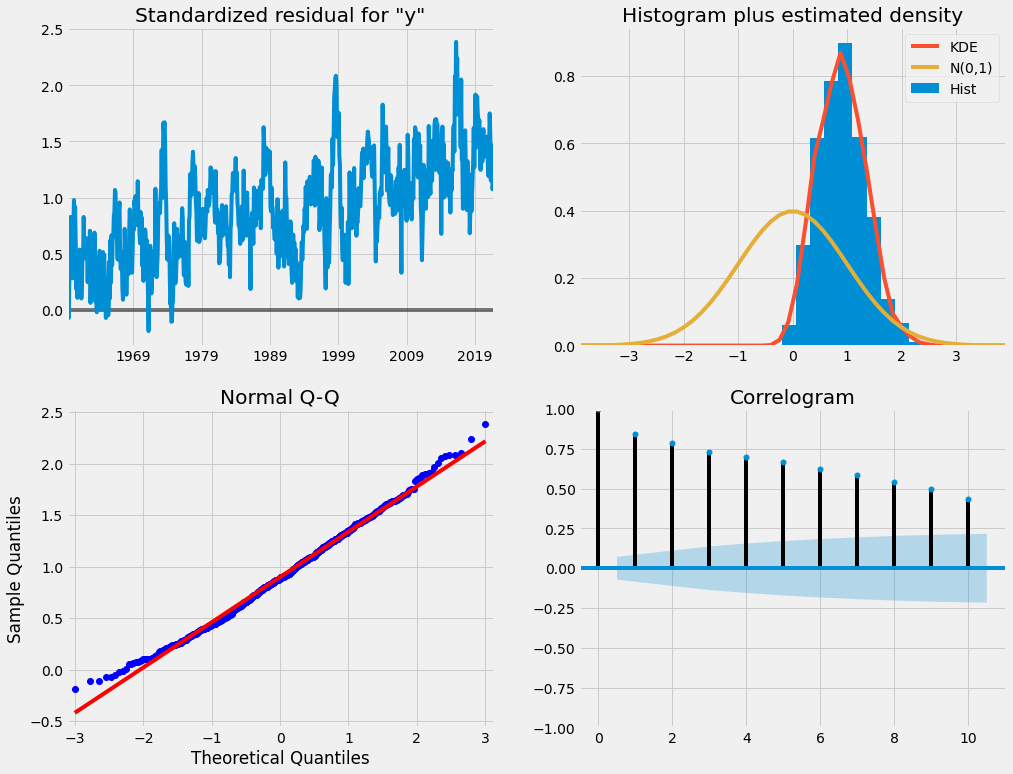

In [27]:
mod1 = sm.tsa.statespace.SARIMAX(y,
                               order=(0, 0, 0),
                               seasonal_order=(0, 1, 0, 12),
                               enforce_stationarity=False,
                               enforce_invertibility=False)

results1 = mod1.fit(disp=False)

results1.plot_diagnostics(figsize=(15, 12))
plt.show()


## Prévision


In [28]:
# juste pour remettre le bon ordre
mod = sm.tsa.statespace.SARIMAX(y,
                               order=(1, 1, 1),
                               seasonal_order=(3, 1, 3, 12),
                               enforce_stationarity=False,
                               enforce_invertibility=False)

results = mod.fit(disp=False)

In [29]:
pred = results.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=True)
pred_ci = pred.conf_int()

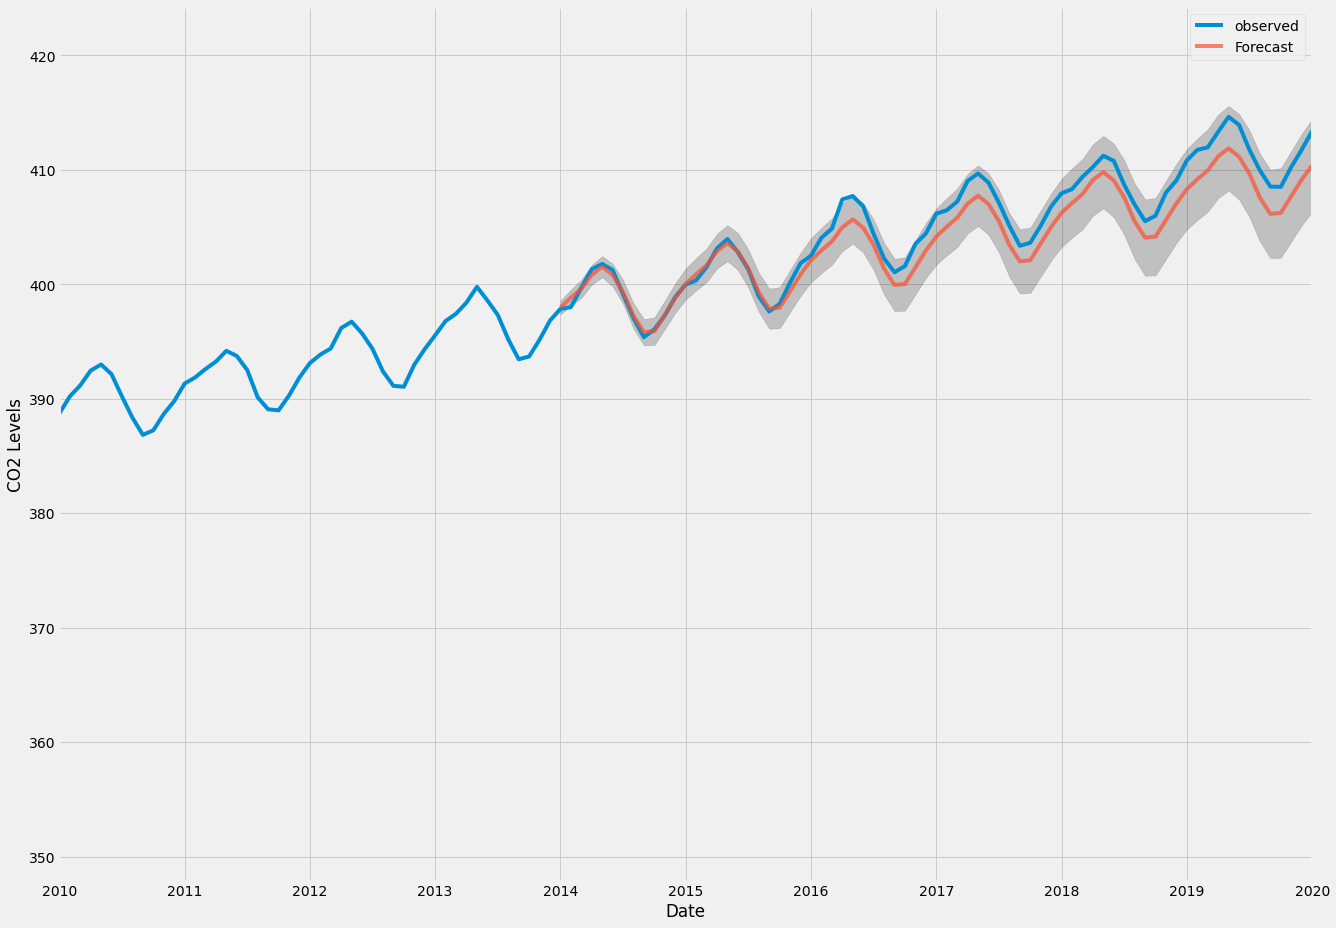

In [30]:
ax = y['1990':].plot(label='observed', figsize=(20, 15))
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.xlim([480., 600.])
plt.show()

L’argument "dynamic = False" garantit que nous produisons des prévisions avec un pas d’avance, ce qui signifie que les prévisions sont générées à chaque point en utilisant l’historique complet jusque-là.


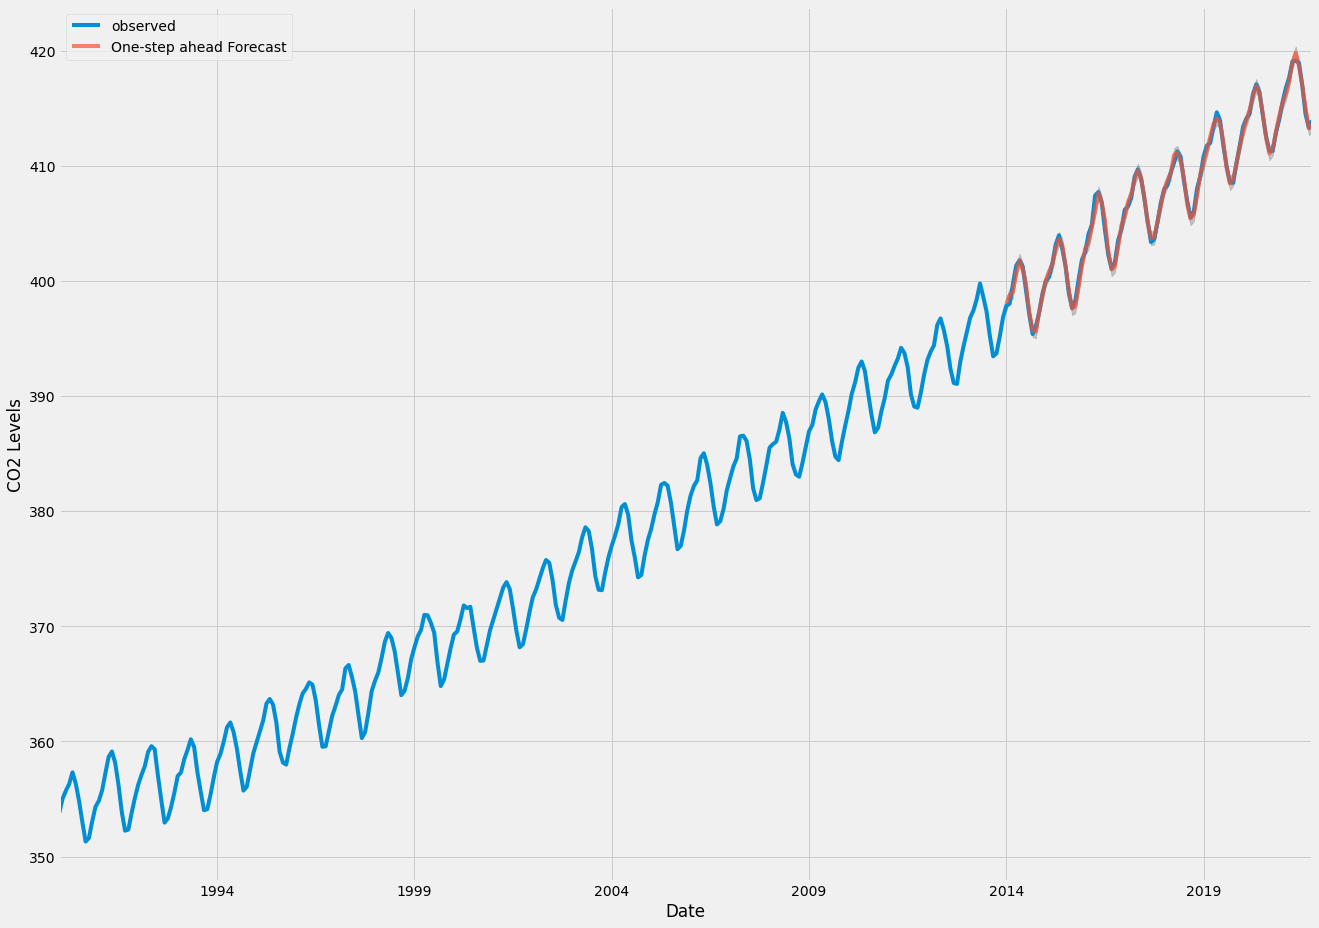

In [31]:
pred = results.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['1990':].plot(label='observed', figsize=(20, 15))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()


## Calcul de la précision des prévisions

- l’erreur MSE (Mean Squared Error), qui résume l’erreur moyenne de nos prévisions. 

Pour chaque valeur prédite, nous calculons sa distance à la valeur vraie et comparons le résultat. 

In [32]:
y_forecasted = pred.predicted_mean
y_truth = y['2014-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.13


Cependant, une meilleure représentation de notre véritable pouvoir prédictif peut être obtenue en utilisant des prévisions dynamiques. Dans ce cas, nous n’utilisons que les informations de la série chronologique jusqu’à un certain point. Par la suite, les prévisions sont générées à l’aide des valeurs des points de temps prévisionnels précédents.

L'erreur va augmenter. 

In [33]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

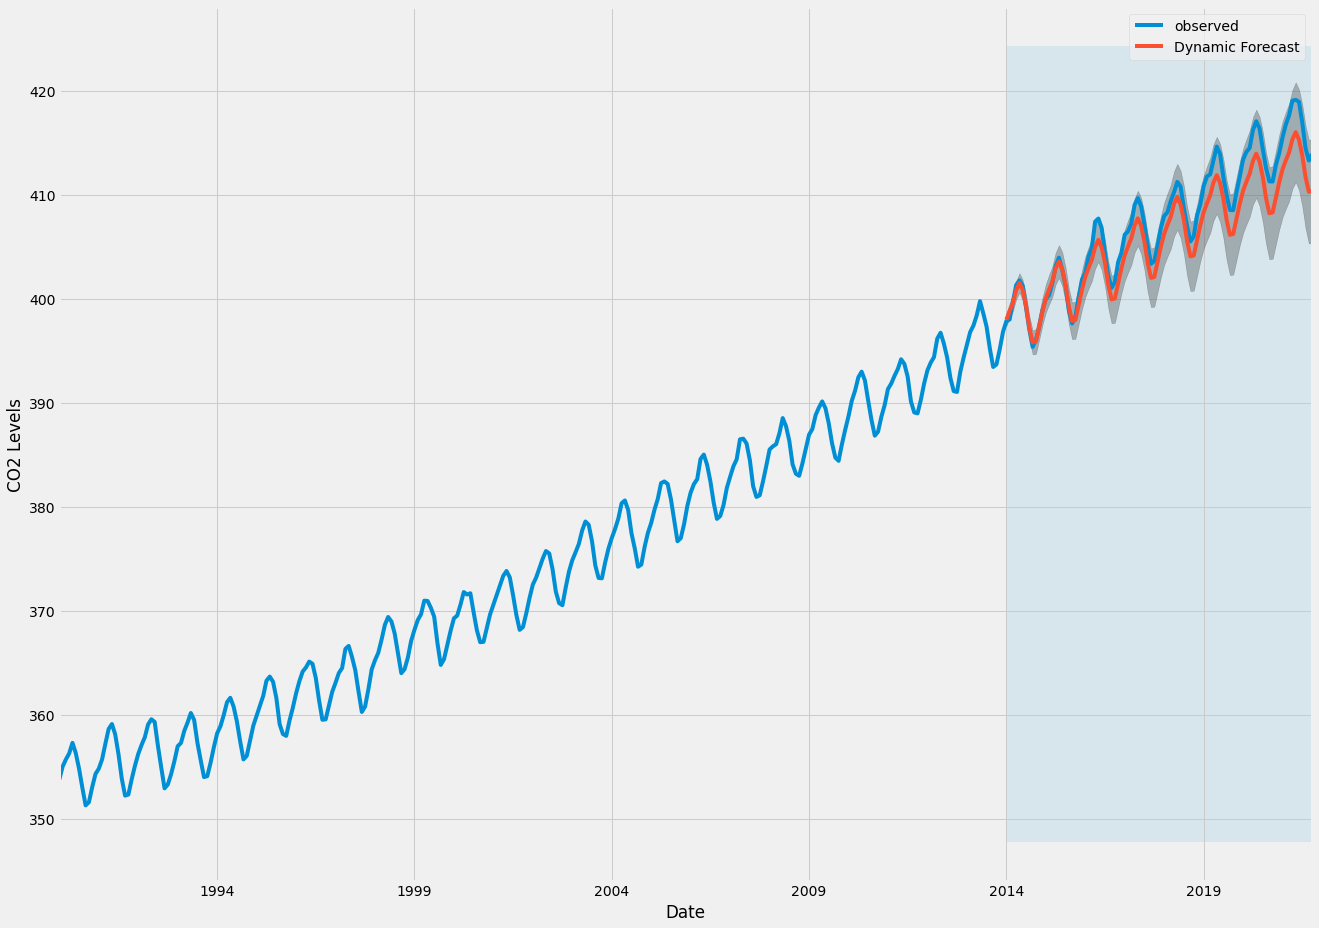

In [34]:
ax = y['1990':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
               pred_dynamic_ci.iloc[:, 0],
               pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2014-01-01'), y.index[-1],
                alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [35]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 4.07


# Production et visualisation des prévisions

In [36]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()


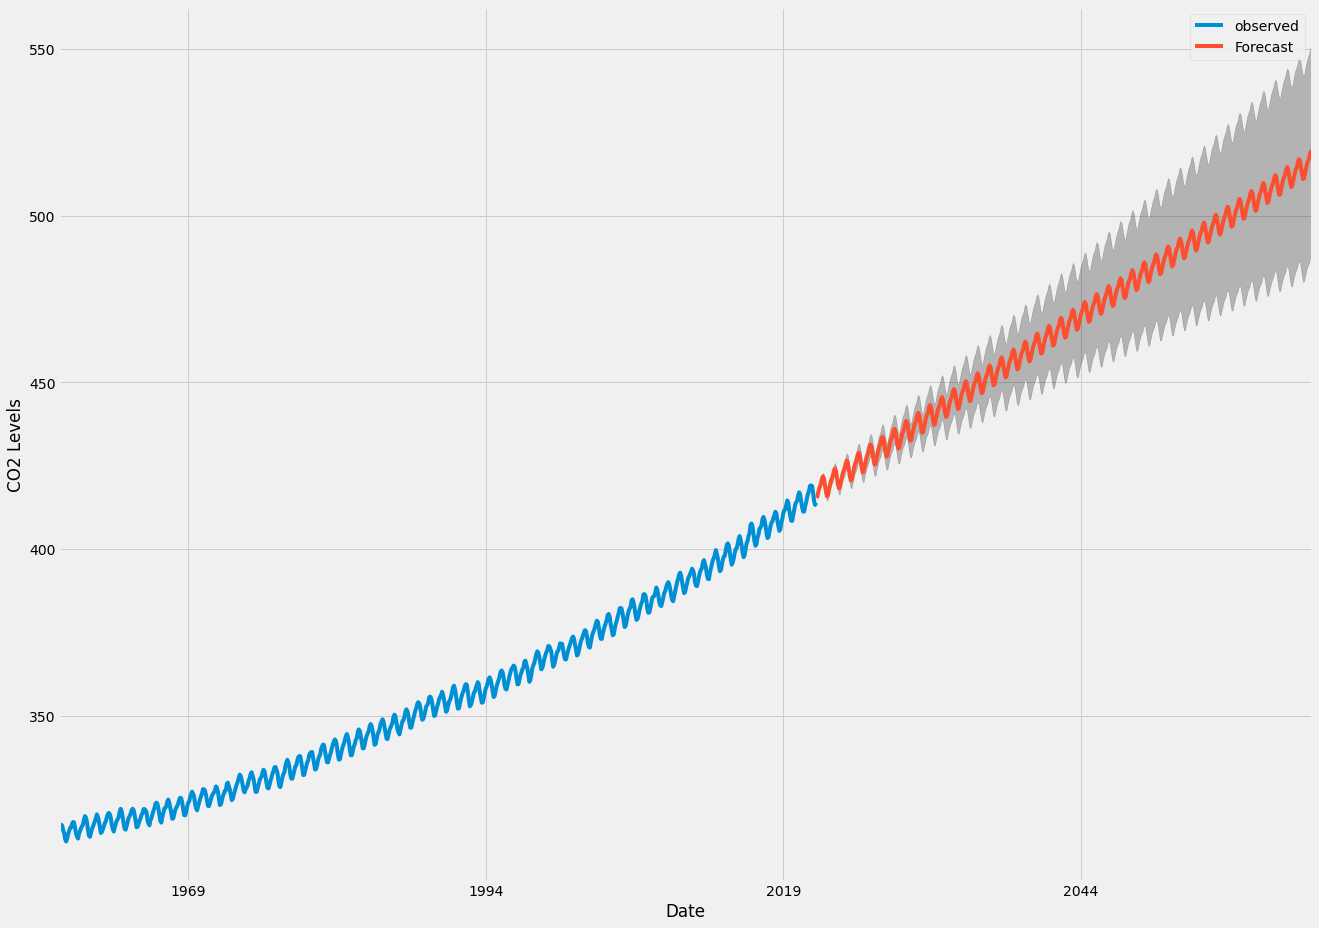

In [37]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()